# Generación de un modelo a partir de uno modelo pre-entrenado
---
### Montar la carpeta de Google Drive y definir constantes para trabajar

In [10]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = '/content/DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
### Preparación de Dataset

Para poder trabajar con el dataset se debe:
1. Copiar el archivo Fingers.zip en la carpeta drive de los datos (establecida para este script en DATOS_DIR).
2. Descomprimir con Unzip los archivos

In [ ]:
import zipfile
import os

# Descomprimir en la misma carpeta
with zipfile.ZipFile(os.path.join(DATOS_DIR, 'Fingers/Fingers.zip'), 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DIR)

# por si se nececita borrar la carpeta, descomentar
#!rm -r Fingers/DATOS

### Carga datos de entrenamiento y prueba

En esta sección se cargan todas las imagenes que se encuentran en subcarpetas.
Se obtiene un listado de todos los archivos (**glob.glob**) y a partir de este se cargan las imágenes, se escalan para que los niveles queden entre 0 y 1 y se agregan a una lista. También se extrae del nombre la clase a la que pertenece la imagen (la cantidad de dedos de la mano es parte del nombre del archivo xxxx_1L.png).
Crea tres subconjuntos de datos: entrenamiento, validación y prueba.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

def import_data(data_dir):

    img_list = glob.glob(data_dir)      # Obtener la lista de archivos de imágenes

    assert len(img_list) > 0, IMG_ERROR # verifica que la ruta sea correcta y tenga al menos 1 imagen

    img_data = []  # lista de imagenes
    lbl_data = []  # lista de etiquetas

    img_count = len(img_list)
    for i, img_path in enumerate(img_list):

        img = Image.open(img_path)          # Carga imagen
        img = np.array(img) / np.max(img)   # Normaliza los píxeles entre 0 y 1
        img = img.reshape((*img.shape, 1))  # Formatea la imagen para TF: WxH => WxHx1. Asegura formato de batch ¿Qué es esto?

        # Almacenar la imagen y la etiqueta
        img_data.append(img)
        # ej. nombre de archivo: 000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png
        lbl_data.append(int(img_path[-6]))  # Extrae la cantidad de dedos del nombre del archivo

        # Mostrar progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100 * i / img_count), end="")

    print("\rCargando imágenes: 100.00%% (%d) \n" % img_count)

    return np.array(img_data), np.array(lbl_data)


# carga las imagenes a partir de los nombres de archivos
x_train, y_train = import_data(LOCAL_DIR+"Fingers/train/*/*.png")

# carga las imagenes a partir de los nombres de archivos
x_test, y_test = import_data(LOCAL_DIR+"Fingers/test/*/*.png")

# separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.30, shuffle = True)


Cargando imágenes: 100.00% (17999) 

Cargando imágenes: 100.00% (3600) 



In [13]:
# clases (0..5) por ejemplo
display(y_train)
# cantidad de ejemplos por clase (0..5)
display(np.bincount(y_train))

array([3, 2, 2, ..., 2, 0, 1])

array([2085, 2096, 2109, 2084, 2099, 2126])

### Genera y entrena el modelo

In [ ]:
EPOCAS = 100
LOTES  = 128
PACIENCIA=5
IMG_SIZE = x_train.shape[1:]
N_CLASSES = len(np.unique(y_train))
ACTIVA =LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input( shape=IMG_SIZE ))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation = ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = optimizers.Adam(0.001)
# Observar que con "sparse_categorical_crossentropy" no hace falta codificacion one-hot para las clases
model.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, min_delta=0.001, restore_best_weights=True )

# entrena el modelo y guarda la historia del progreso
H = model.fit(x_train,
              y_train,
              batch_size = LOTES,
              epochs = EPOCAS,
              validation_data = (x_val, y_val),
              callbacks=[early_stop]
             )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,174 (1.02 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 276ms/step - accuracy: 0.7448 - loss: 0.7667 - val_accuracy: 0.9876 - val_loss: 0.0433
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.9923 - loss: 0.0317 - val_accuracy: 0.9996 - val_loss: 0.0077
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.9988 - loss: 0.0076 - val_accuracy: 0.9996 - val_loss: 0.0030
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 9.1350e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 1.0000 - loss: 7.1031e-04 - val_accuracy: 1.0000 - val_loss: 4.7884e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 1.0000 - loss: 5.0598e-04 - val_accuracy: 1.0000 - val_loss: 3.4442e-04
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 1.00

### Graficas y métricas de la evolución del modelo

In [17]:
# %% evalua el modelo para entrenamiento y testeo
pred_train = model.evaluate(x_train, y_train, verbose=0)
pred_test = model.evaluate(x_test, y_test, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (H.history['accuracy'][-1]*100))
print("Efectividad del modelo con datos de validacion...: %6.2f%%" % (H.history['val_accuracy'][-1]*100))
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred_test[1]*100))

fig = make_subplots(rows=1, cols=2, subplot_titles=("Pérdida", "Precisión"))

fig.add_trace(go.Scatter(y=H.history["loss"], mode='lines', name='train_loss'), row=1, col=1)
fig.add_trace(go.Scatter(y=H.history["val_loss"], mode='lines', name='val_loss'), row=1, col=1)

fig.add_trace(go.Scatter(y=H.history["accuracy"], mode='lines', name='train_acc'), row=1, col=2)
fig.add_trace(go.Scatter(y=H.history["val_accuracy"], mode='lines', name='val_acc'), row=1, col=2)

fig.update_layout(
    title="Entrenamiento y Validación",
    xaxis_title="Época",
    yaxis_title="Valor",
    legend_title="Métricas",
    width=1200,
    height=600,
    template="plotly_white"  # Plantilla de diseño
)


fig.show()


Efectividad del modelo con datos de entrenamiento: 100.00%
Efectividad del modelo con datos de validacion...: 100.00%
Efectividad del modelo con datos de Prueba.......: 100.00%


---
### Prueba con datos de prueba modificados

Prueba del modelo con ejemplos de datos "no vistos" durante el entrenamiento. En este caso los datos de prueba se encuentran rotados al azar entre -45 y 45 grados.


In [16]:
from random import random
from scipy.ndimage import rotate

def rotar_al_azar(data_imgs, max_ang):
    result = np.empty_like(data_imgs)
    for i, img in enumerate(data_imgs):
        ang = (random() - 0.5) * 2 * max_ang #random genera nros aleatorios entre 0 y 1
        result[i] = rotate(img, ang, reshape=False, mode='reflect')
    return result

x_test_rot = rotar_al_azar(x_test, 45)

# evalua el modelo con los datos de testeo
pred = model.evaluate(x_test_rot, y_test, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))

# Muestra 10 de las imágenes rotadas
num_imagenes_a_mostrar = 10
imagenes_rotadas = x_test_rot[:num_imagenes_a_mostrar]

Efectividad del modelo con datos de Prueba.......:  69.56%


### Prueba con Rotaciones Progresivas

Efectividad del modelo con datos de Prueba rotado   0 grados:  99.89%
Efectividad del modelo con datos de Prueba rotado   5 grados:  99.25%
Efectividad del modelo con datos de Prueba rotado  10 grados:  93.58%
Efectividad del modelo con datos de Prueba rotado  15 grados:  81.69%
Efectividad del modelo con datos de Prueba rotado  20 grados:  70.92%
Efectividad del modelo con datos de Prueba rotado  25 grados:  63.50%
Efectividad del modelo con datos de Prueba rotado  30 grados:  53.42%
Efectividad del modelo con datos de Prueba rotado  35 grados:  47.36%
Efectividad del modelo con datos de Prueba rotado  40 grados:  43.97%
Efectividad del modelo con datos de Prueba rotado  45 grados:  41.83%
Efectividad del modelo con datos de Prueba rotado  50 grados:  40.50%
Efectividad del modelo con datos de Prueba rotado  55 grados:  38.97%
Efectividad del modelo con datos de Prueba rotado  60 grados:  37.50%
Efectividad del modelo con datos de Prueba rotado  65 grados:  35.81%
Efectividad del mode

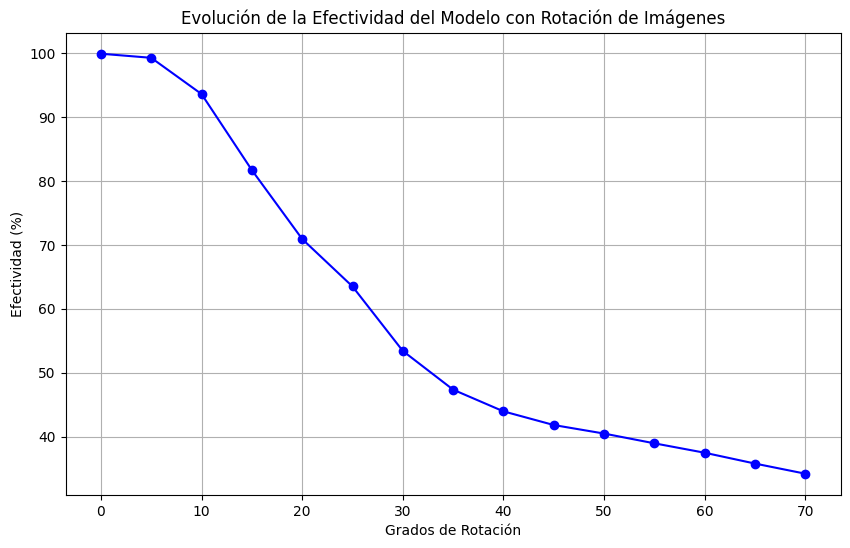

In [ ]:

def rotar_grados(data_imgs, ang):
    result = np.empty_like(data_imgs)
    for i, img in enumerate(data_imgs):
        result[i] = rotate(img, ang, reshape=False, mode='reflect') # El modo 'reflect' rellena los bordes reflejando la imagen para que no se tomen como un patrón
    return result

# Lista para almacenar los resultados de la efectividad
efectividades = []
grados_rotacion = []

for i in range(15):
    grados = i * 5
    x_test_rot = rotar_grados(x_test, grados)

    # Evalúa el modelo con los datos de prueba rotados
    pred = model.evaluate(x_test_rot, y_test, verbose=0)
    efectividad = pred[1] * 100
    print("Efectividad del modelo con datos de Prueba rotado %3d grados: %6.2f%%" % (grados, efectividad))

    # Almacena los resultados
    efectividades.append(efectividad)
    grados_rotacion.append(grados)

# Crea el gráfico
plt.figure(figsize=(10, 6))
plt.plot(grados_rotacion, efectividades, marker='o', linestyle='-', color='b')
plt.title('Evolución de la Efectividad del Modelo con Rotación de Imágenes')
plt.xlabel('Grados de Rotación')
plt.ylabel('Efectividad (%)')
plt.grid(True)
plt.show()

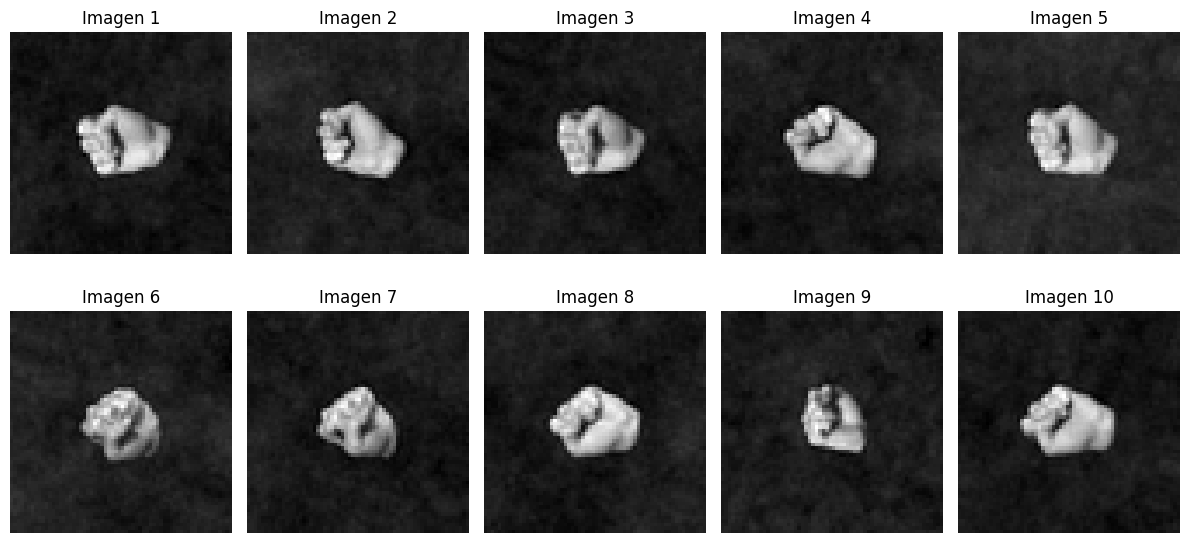

In [9]:
# Muestra 10 de las imágenes rotadas
num_imagenes_a_mostrar = 10
imagenes_rotadas = x_test_rot[:num_imagenes_a_mostrar]

# Configura la cuadrícula para mostrar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()  # Aplanar la matriz de ejes para facilitar el acceso

for i in range(num_imagenes_a_mostrar):
    axes[i].imshow(imagenes_rotadas[i], cmap='gray')  # Ajusta el colormap según el tipo de imagen
    axes[i].axis('off')  # Oculta los ejes
    axes[i].set_title(f'Imagen {i+1}')

plt.tight_layout()
plt.show()